# Examples of neural reparamterization for structural optimization

In [the paper](https://arxiv.org/abs/1909.04240), we run every optimization for 1000 steps and focus on the largest problems. These are pretty slow to run, so to keep this notebook interactive we'll focus on smaller examples trained for fewer steps.

In [0]:
# Install dependencies with pip. Only run this once.
! pip install -q tf-nightly git+https://github.com/google-research/neural-structural-optimization.git

In [1]:
# Copyright 2019 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from IPython import display
from PIL import Image
import seaborn
import matplotlib.pyplot as plt
import xarray
import pandas as pd

from neural_structural_optimization import pipeline_utils
from neural_structural_optimization import problems
from neural_structural_optimization import models
from neural_structural_optimization import topo_api
from neural_structural_optimization import train

/Users/kwp/Projects/neural-structural-optimization/neural_structural_optimization/autograd_lib.py:36: UserWarning: sksparse.cholmod not installed. Falling back to SciPy/SuperLU, but simulations will be about twice as slow.
  'sksparse.cholmod not installed. Falling back to SciPy/SuperLU, but '


In [3]:
def train_all(problem, max_iterations, cnn_kwargs=None):
    args = topo_api.specified_task(problem)
    if cnn_kwargs is None:
        cnn_kwargs = {}
    
    print("train unet...")
    model = models.UNetModel(args=args)
    ds_unet = train.train_lbfgs(model, max_iterations)
    
    print("train fcn...")
    model = models.FCNModel(args=args)
    ds_fcn = train.train_lbfgs(model, max_iterations)
    
    print("train cnn...")
    model = models.CNNModel(args=args, **cnn_kwargs)
    ds_cnn = train.train_lbfgs(model, max_iterations)
    
    print("trian mma...")
    model = models.PixelModel(args=args)
    ds_mma = train.method_of_moving_asymptotes(model, max_iterations)

    print("train oc...")
    model = models.PixelModel(args=args)
    ds_oc = train.optimality_criteria(model, max_iterations)
    
    print("train pixcel...")
    model = models.PixelModel(args=args)
    ds_pix = train.train_lbfgs(model, max_iterations)

    dims = pd.Index(['cnn-lbfgs', 'fcn-lbfgs', 'unet-lbfgs', 'mma', 'oc', 'pixel-lbfgs'], name='model')
    return xarray.concat([ds_cnn, ds_fcn, ds_unet, ds_mma, ds_oc, ds_pix], dim=dims)

## MBB Beam (Figure 2 from paper)

Note that we tweaked the CNN model slightly original version of the paper, which results in a slightly worse design in this particular case.

See the updated figure in our [latest revision](https://openreview.net/forum?id=Bkec3m3q8B) on OpenReview.net.

In [4]:
problem = problems.mbb_beam(height=32, width=64)
max_iterations = 200

# can't upscale by exactly 8x for a 60x20 design region, so upscale by
# only 4x instead
%time ds = train_all(problem, max_iterations, cnn_kwargs=dict(resizes=(1, 1, 2, 2, 1)))

train unet...


/Users/kwp/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Users/kwp/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


train fcn...
train cnn...
trian mma...
train oc...
train pixcel...
CPU times: user 35min 24s, sys: 5min 23s, total: 40min 48s
Wall time: 29min 32s


In [5]:
ds

<xarray.Dataset>
Dimensions:  (model: 6, step: 201, x: 64, y: 32)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 ... 193 194 195 196 197 198 199 200
  * model    (model) object 'cnn-lbfgs' 'fcn-lbfgs' ... 'oc' 'pixel-lbfgs'
Dimensions without coordinates: x, y
Data variables:
    loss     (model, step) float64 476.4 342.6 602.1 271.3 ... nan nan nan nan
    design   (model, step, y, x) float64 0.6746 0.6803 0.6828 ... nan nan nan

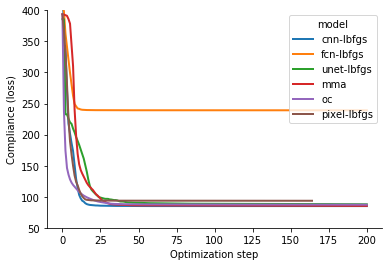

In [6]:
ds.loss.transpose().to_pandas().cummin().loc[:2000].plot(linewidth=2)
plt.ylim(50, 400)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

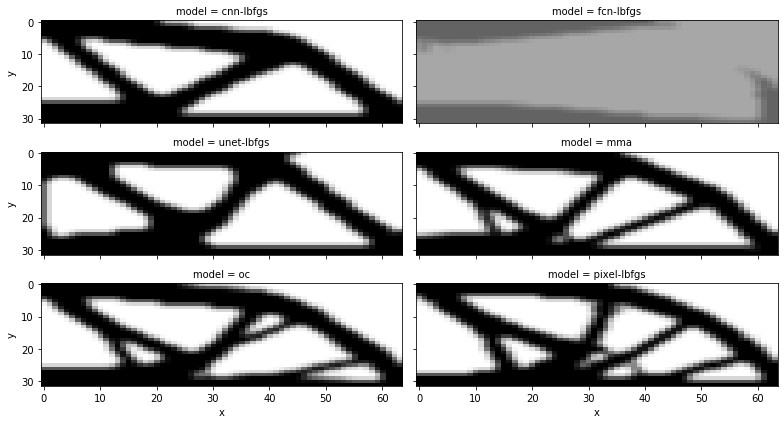

In [7]:
ds.design.sel(step=100).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

If desired, designs can also be converted into `PIL.Image` objects with the `pipeline_utils.image_from_design` utility. This is convenient for exporting single frames or creating GIFs:

In [8]:
def save_gif_movie(images, path, duration=200, loop=0, **kwargs):
    images[0].save(path, save_all=True, append_images=images[1:],
                   duration=duration, loop=loop, **kwargs)

In [10]:
images = [
    pipeline_utils.image_from_design(design, problem)
    for design in ds.design.sel(model='unet-lbfgs')[:200]
]

In [11]:
save_gif_movie([im.resize((5*120, 5*20)) for im in images], 'movie.gif')

This produces the following movie of the optimization process:

<img src="https://github.com/google-research/neural-structural-optimization/raw/master/notebooks/movie.gif" />

## MBB beam with a larger grid

In [24]:
problem2 = problems.PROBLEMS_BY_NAME['mbb_beam_192x64_0.4']
max_iterations = 100
%time ds2 = train_all(problem, max_iterations)

train unet...


/Users/kwp/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


train fcn...
train cnn...
trian mma...
train oc...
train pixcel...
CPU times: user 18min 34s, sys: 2min 46s, total: 21min 20s
Wall time: 15min 17s


Now, the CNN-LBFGS model performs best:

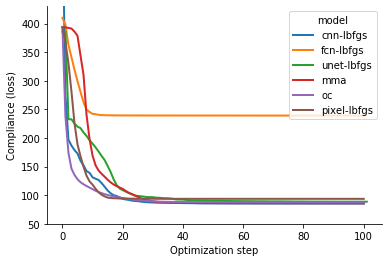

In [29]:
ds2.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylim(50, 430)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

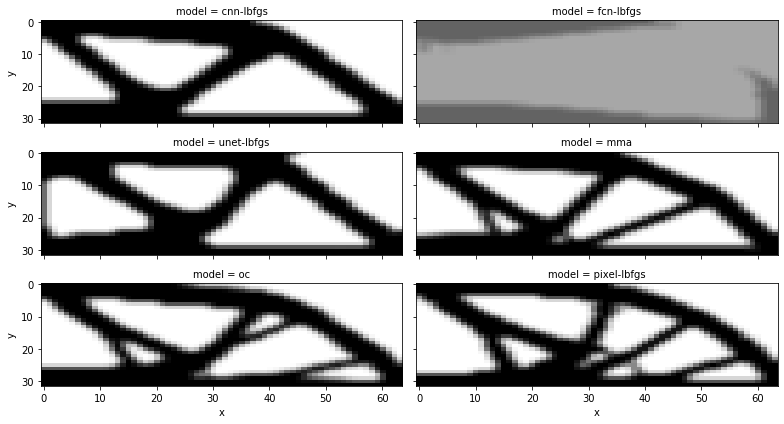

In [30]:
# the pixel-lbfgs does not run for the full 100 steps (it terminates
# early due to reaching a local minima), so use fill() to forward fill
# to the last valid design.
ds2.design.ffill('step').sel(step=100).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.suptitle(problem.name, y=1.02);

## Multistory building

In [12]:
problem3 = problems.PROBLEMS_BY_NAME['multistory_building_64x128_0.4']
max_iterations = 100  # keep things fast
%time ds3 = train_all(problem, max_iterations)

train unet...


/Users/kwp/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


train fcn...
train cnn...
trian mma...
train oc...
train pixcel...
CPU times: user 18min 28s, sys: 2min 52s, total: 21min 20s
Wall time: 15min 28s


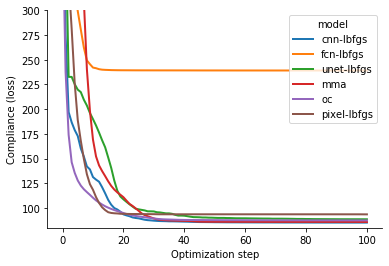

In [15]:
ds3.loss.transpose().to_pandas().cummin().loc[:100].plot(linewidth=2)
plt.ylim(80, 300)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()
plt.suptitle(problem.name);

For fun, we'll examine designs at different time-steps.

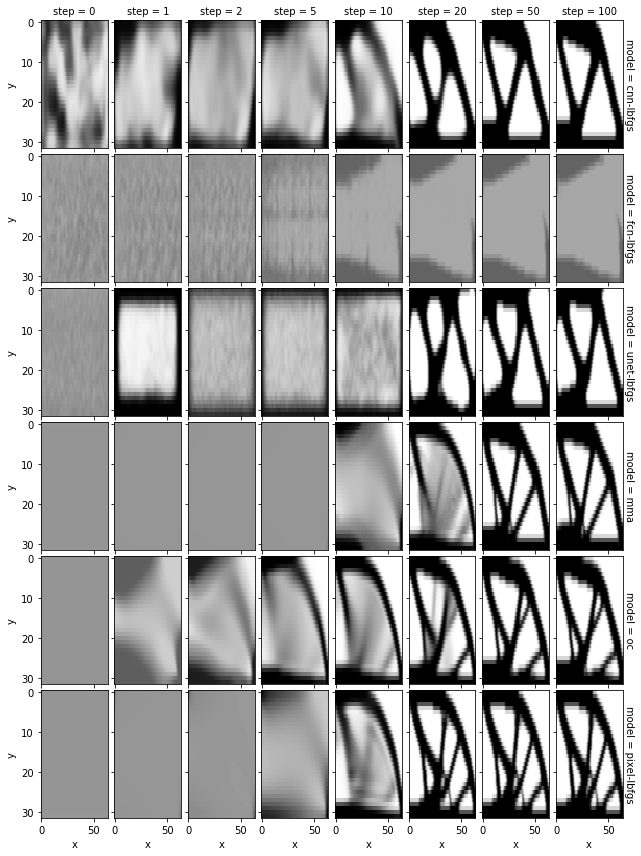

In [16]:
ds3.design.sel(step=[0, 1, 2, 5, 10, 20, 50, 100]).plot.imshow(
    row='model', col='step', x='x', y='y', size=2, aspect=0.5,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.suptitle(problem.name, y=1.02);

## Thin support bridge

In [17]:
# we really need more iterations to see the CNN-LBFGS method dominate
problem4 = problems.PROBLEMS_BY_NAME['thin_support_bridge_128x128_0.2']
max_iterations = 200
%time ds4 = train_all(problem, max_iterations)

train unet...


/Users/kwp/opt/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Users/kwp/opt/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


train fcn...
train cnn...
trian mma...
train oc...
train pixcel...
CPU times: user 35min 5s, sys: 5min 19s, total: 40min 25s
Wall time: 28min 44s


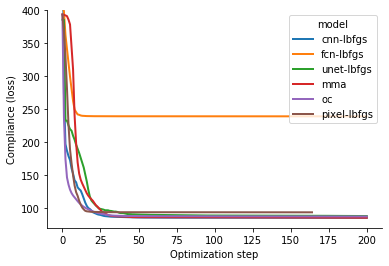

In [20]:
ds4.loss.transpose().to_pandas().cummin().plot(linewidth=2)
plt.ylim(70, 400)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()
plt.suptitle(problem.name);

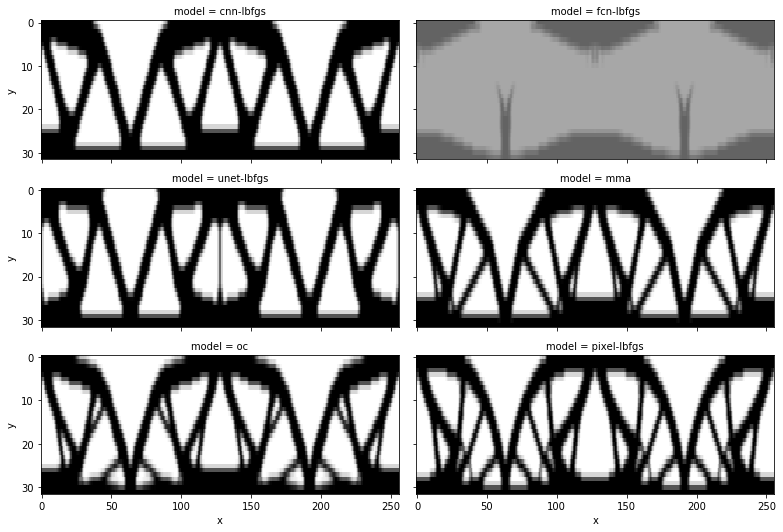

In [23]:
(xarray.concat([ds4.design, ds4.design.sel(x=slice(None, None, -1))] * 2, dim='x')
 .sel(step=150)
 .plot.imshow(
    col='model', x='x', y='y', size=2.5, aspect=2, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys'))
plt.suptitle(problem.name, y=1.02);